In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

# 1) Load data (samakan path ke file kamu)
csv_path = "../data/ramen-ratings.csv"
df = pd.read_csv(csv_path)

In [16]:
display(df.head())
display(df.describe(include='all').T)

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Review #,2580.0,NaN,NaN,NaN,1290.5,744.926171,1.0,645.75,1290.5,1935.25,2580.0
Brand,2580,355,Nissin,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Variety,2580,2413,Beef,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Style,2578,7,Pack,1531,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,2580,38,Japan,352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stars,2580,51,4,384,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Top Ten,41,38,\n,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
possible_cols = df.columns.tolist()
text_col = "Variety" if "Variety" in possible_cols else None
num_cols  = [c for c in ["Stars"] if c in possible_cols]
cat_cols  = [c for c in ["Style", "Country", "Top Ten"] if c in possible_cols]

feature_cols = []
if text_col: feature_cols.append(text_col)
feature_cols += num_cols + cat_cols

missing_needed = {"Variety","Stars","Style","Country"} - set(possible_cols)
print(f"\nKolom fitur yang dipakai: {feature_cols}")
if missing_needed:
    print(f"Catatan: Beberapa kolom umum tidak ada di CSV ini: {missing_needed}. Tidak masalah, lanjut pakai yang tersedia.")


Kolom fitur yang dipakai: ['Variety', 'Stars', 'Style', 'Country', 'Top Ten']


In [19]:
TOP_K = 5  # ubah ke None bila ingin semua brand
df = df.copy()
df = df[df["Brand"].notna()]
if TOP_K:
    top_brands = df["Brand"].value_counts().nlargest(TOP_K).index
    df = df[df["Brand"].isin(top_brands)]

print("Distribusi kelas (Brand)")
print(df["Brand"].value_counts())

Distribusi kelas (Brand)
Brand
Nissin      381
Nongshim     98
Maruchan     76
Mama         71
Paldo        66
Name: count, dtype: int64


In [20]:
X = df[feature_cols].copy()
y = df["Brand"].astype("category")
class_names = list(y.cat.categories)
y = y.cat.codes         

In [22]:
transformers = []
if text_col:
    transformers.append(
        ("text", TfidfVectorizer(min_df=2, ngram_range=(1,2)), text_col)
    )

if num_cols:
    transformers.append(
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols)
    )

if cat_cols:
    transformers.append(
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    )

preprocess = ColumnTransformer(transformers=transformers, remainder="drop")

model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(kernel="linear", random_state=42))  # linear seperti di slide
])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi (test): {acc*100:.2f}%")
print("===== Classification Report =====")
print(classification_report(y_test, y_pred, target_names=class_names))

Akurasi (test): 88.49%
===== Classification Report =====
              precision    recall  f1-score   support

        Mama       0.74      1.00      0.85        14
    Maruchan       1.00      0.73      0.85        15
      Nissin       0.92      0.94      0.93        77
    Nongshim       0.94      0.75      0.83        20
       Paldo       0.73      0.85      0.79        13

    accuracy                           0.88       139
   macro avg       0.87      0.85      0.85       139
weighted avg       0.90      0.88      0.88       139



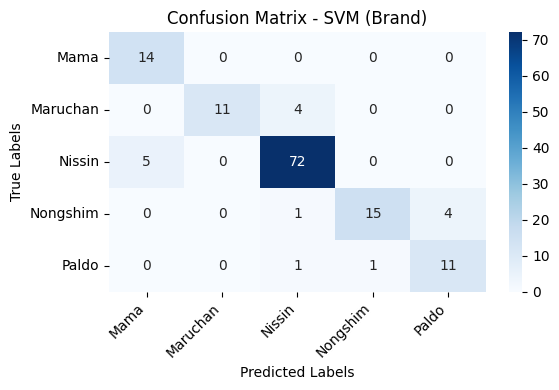

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM (Brand)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
model_rbf = Pipeline(steps=[
    ("prep", preprocess),
    ("svc", SVC(kernel="rbf", gamma="scale", random_state=42))
])

model_rbf.fit(X_train, y_train)
y_pred_rbf = model_rbf.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"Akurasi kernel RBF : {acc_rbf*100:.2f}%")

# Reduksi dimensi ke 2D agar bisa divisualkan
X_prep = preprocess.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_prep)

# Plot 2D hasil PCA untuk Linear dan RBF
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='rainbow', alpha=0.8)
plt.title("Visualisasi Data Ramen (Linear SVM)")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred_rbf, cmap='rainbow', alpha=0.8)
plt.title("Visualisasi Klasifikasi Ramen (Kernel RBF)")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.tight_layout()
plt.show()

Akurasi kernel RBF : 77.70%


NameError: name 'PCA' is not defined